# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах:
* /datasets/geo_data_0.csv.
* /datasets/geo_data_1.csv. 
* /datasets/geo_data_2.csv.
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

# Содержание проекта

<a href='#step1'>1.Загрузка и подготовка данных</a>

<a href='#step2'>2.Обучение и проверка модели</a>
* Разделение данных на обучающую и валидационные выборки
* Стандартизация данных
* Обучение моделей
* Значение RMSE на валидационной выборки и средний запас предсказанного сырья для каждого региона
* Вывод

<a href='#step3'>3.Подготовка к расчету прибыли</a>
* Значимые константы
* Достаточный объем сырья для безубыточной разработки в регионе
* Вывод

<a href='#step4'>4.Расчет прибыли и рисков</a>
* Распределение прибыли в каждом и регионов
* Средняя прибыль
* Доверительный интервал
* Риск убытков
* Рекомендованнный регион для разработки

# 1. Загрузка и подготовка данных<a id='step1'></a>

импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error

from scipy import stats

загружим данные

In [2]:
try:
    data_0 = pd.read_csv('geo_data_0.csv')
    data_1 = pd.read_csv('geo_data_1.csv')
    data_2 = pd.read_csv('geo_data_2.csv')
    
except:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')

осмотрим данные

In [3]:
print('data_0')
display(data_0.head())
print()

print('data_1')
display(data_1.head())
print()

print('data_2')
display(data_2.head())

data_0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



data_1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



data_2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Все данные прочтены верно и готовы к дальнейшей подготовке

In [4]:
print('data_0')
display(data_0.info())
print()

print('data_1')
display(data_1.info())
print()

print('data_2')
display(data_2.info())

data_0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


data_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


data_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Ни в одном из датафреймов нет пропусков и все столбцы имеют адекватные типы данных.

In [5]:
print('data_0')
display(data_0.describe())
print()

print('data_1')
display(data_1.describe())
print()

print('data_2')
display(data_2.describe())

data_0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



data_1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



data_2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


В таблицах data_0 и data_1 признак f2 заметно отличается по масштабу от признаков f0 и f1. То есть для более правильного обучения модели также необходимо стандартизировать признаки. Но этим стоит заняться уже после разделения выборок на тестовую и обучающую. А пока что выделим целевой признак и признаки, по которым он будет предсказываться в отдельные датафреймы

In [6]:
# целевой признак

target_0 = data_0['product']
target_1 = data_1['product']
target_2 = data_2['product']

# обучающие признаки

features_0 = data_0[['f0', 'f1', 'f2']]
features_1 = data_1[['f0', 'f1', 'f2']]
features_2 = data_2[['f0', 'f1', 'f2']]

Фактически мы убрали из рассмотрения колонку id. Так как название месторождения не влияет на его запасы.

Построим гистограмму колонки product для каждого региона.

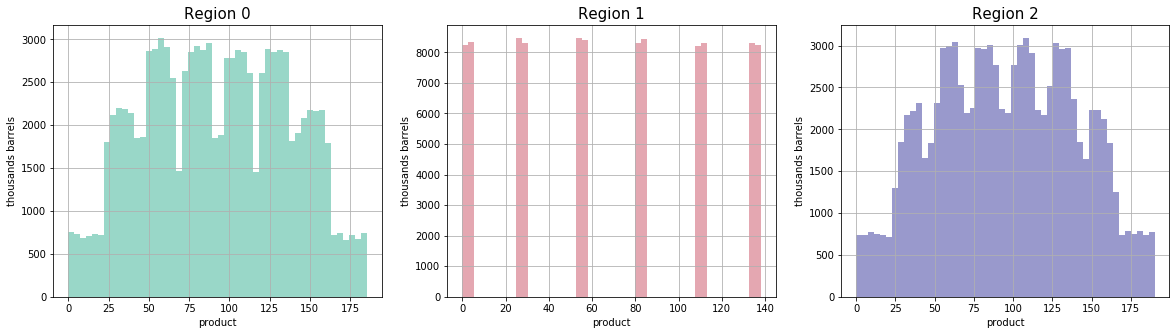

In [7]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

sns.distplot(data_0['product'], bins=50, kde=False, ax=ax[0], color='#009B77')
ax[0].set_title('Region 0', fontsize=15)
ax[0].set_ylabel('thousands barrels')
ax[0].grid(True)

sns.distplot(data_1['product'], bins=50, kde=False, ax=ax[1], color='#BC243C')
ax[1].set_title('Region 1', fontsize=15)
ax[1].set_ylabel('thousands barrels')
ax[1].grid(True)

sns.distplot(data_2['product'], bins=50, kde=False, ax=ax[2], color='#000080')
ax[2].set_title('Region 2', fontsize=15)
ax[2].set_ylabel('thousands barrels')
ax[2].grid(True)

Для регионов 0 и 2 распределение напоминает нормальное, но без явно выраженного пика. Для региона 1 - распределение выглядит очень странно. Очень много месторождений с 0 запасом.

# 2. Обучение и проверка модели

## Разделение данных на обучающую и валидационную выборки

для автоматизации будем хранить не три валидационные/обучающие выборки, а словари из трех элементов - так получится все действия выполнять в циклах.

In [8]:
# создаем словарь с исходными датафреймами

data_dict = {0: data_0, 1: data_1, 2:data_2}

# создаем словари с целевым признаков и признаками для предсказания

target_dict = {0: target_0, 1: target_1, 2:target_2}
features_dict = {0: features_0, 1: features_1, 2:features_2}

In [9]:
# создаем словари с обучающими и валидационными выборками

features_train_dict ={}
target_train_dict = {}

features_valid_dict ={}
target_valid_dict = {}

# делим данные для каждого региона на обучающую и валидационные выборки

for i in range(3):
    features = features_dict[i]
    target = target_dict[i]
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=42)
    
    features_train_dict.update({i:features_train})
    target_train_dict.update({i:target_train})
    
    features_valid_dict.update({i:features_valid})
    target_valid_dict.update({i:target_valid})

In [10]:

# выведем размеры получившихся выборок

for i in range(3):
    
    print('Region - {}; train size - {}; valid size - {}'.format(i, target_train_dict[i].shape[0], target_valid_dict[i].shape[0]))

Region - 0; train size - 75000; valid size - 25000
Region - 1; train size - 75000; valid size - 25000
Region - 2; train size - 75000; valid size - 25000


Валидационная = 75:25

Теперь необходимо стандартизировать данные. Но для начала построим гистогрммы всех признаков для каждого региона и убедимся в том, что они распределены как попало. На каждом графике вертикальной красной линией отметим 0

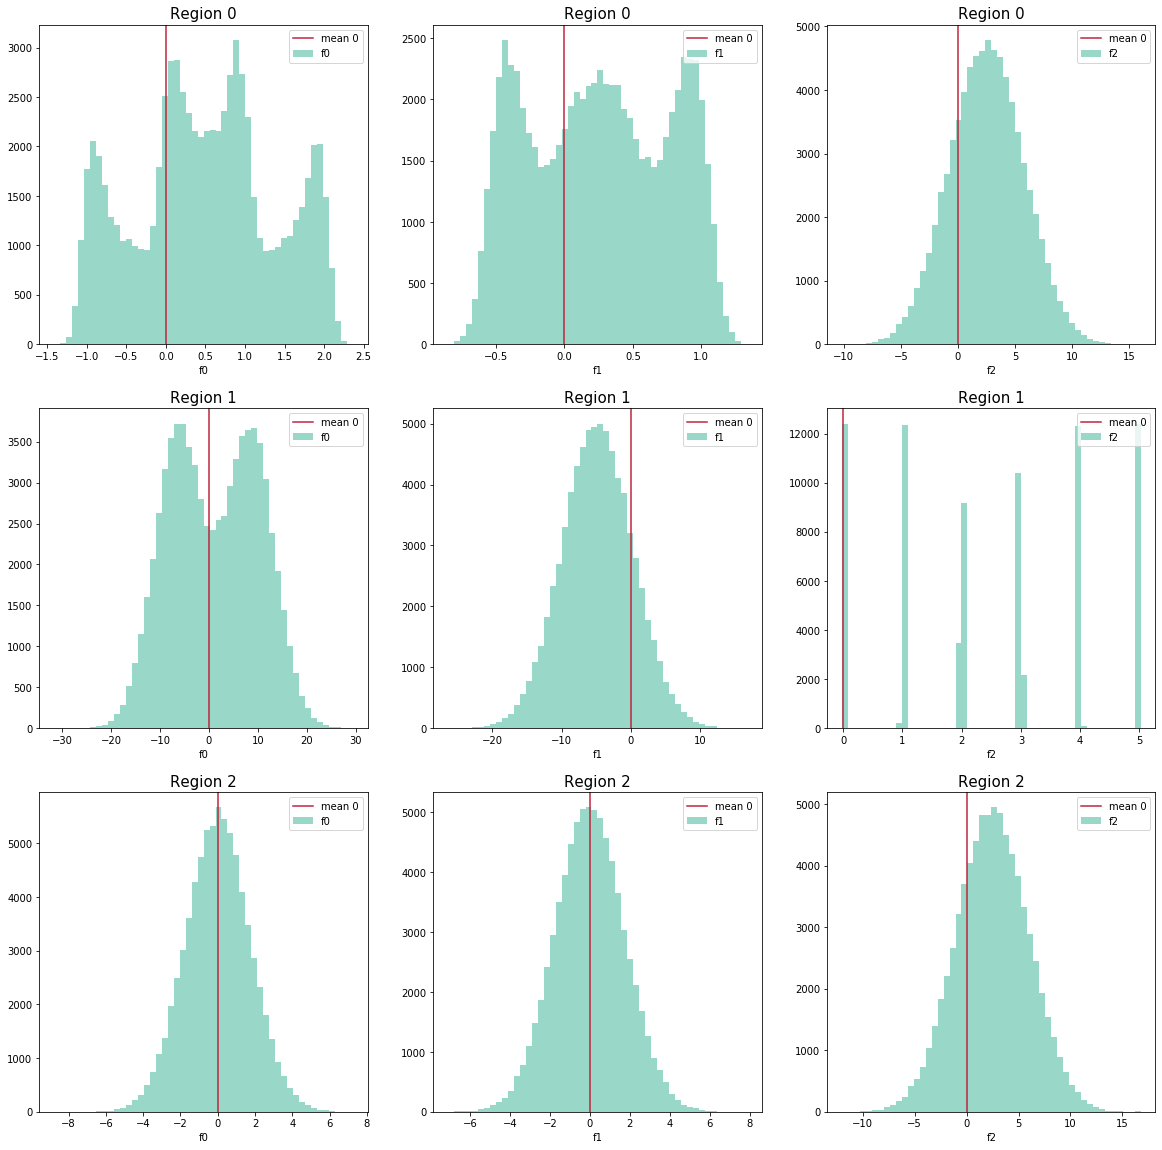

In [11]:
# строим гистограммы признаков до стандартизации

fig, ax = plt.subplots(3,3, figsize=(20,20))

for i in range(3):
    region_name = 'Region ' + str(i)
    for j in range(3):
        column_name = 'f' + str(j)
        
        sns.distplot(features_train_dict[i][column_name], bins=50, kde=False, ax=ax[i,j], label=column_name, color='#009B77')
        ax[i,j].set_title(region_name, fontsize=15)
        ax[i,j].axvline(x=0, color='#BC243C', label='mean 0')
        ax[i,j].legend(loc='upper right')

По построенным гистограммам видно, что только f0 в регионах 1 и 2, а также f1 в регионе 2 распределены симметрично относительно 0 - остальные значительно смещены

## Стандартизация данных

In [12]:
# создаем словари для хранения scaler'ов и стандартизированных признаков в обучающей и валидационной выборках

scaler_dict = {}

features_train_norm_dict ={}
features_valid_norm_dict ={}

# в цикле проходим по всем регионам  и стандартизируем признаки ['f0', 'f1', 'f2'] для обучающей и валидационной выборок

for i in range(3):
    
    scaler = StandardScaler()
    scaler.fit(features_train_dict[i][['f0', 'f1', 'f2']])
    
    norm_features_train = pd.DataFrame(data=scaler.transform(features_train_dict[i][['f0', 'f1', 'f2']]), columns=['f0', 'f1', 'f2'], index=features_train_dict[i].index)
    norm_features_valid = pd.DataFrame(data=scaler.transform(features_valid_dict[i][['f0', 'f1', 'f2']]), columns=['f0', 'f1', 'f2'], index=features_valid_dict[i].index)
    
    features_train_norm_dict.update({i: norm_features_train})
    features_valid_norm_dict.update({i: norm_features_valid})
    scaler_dict.update({i:scaler})

Для того чтобы проверить, что стандартизация проведена верно, снова построим гистограммы всех признаков для 3х регионов - теперь они должны быть распределены с центром в 0

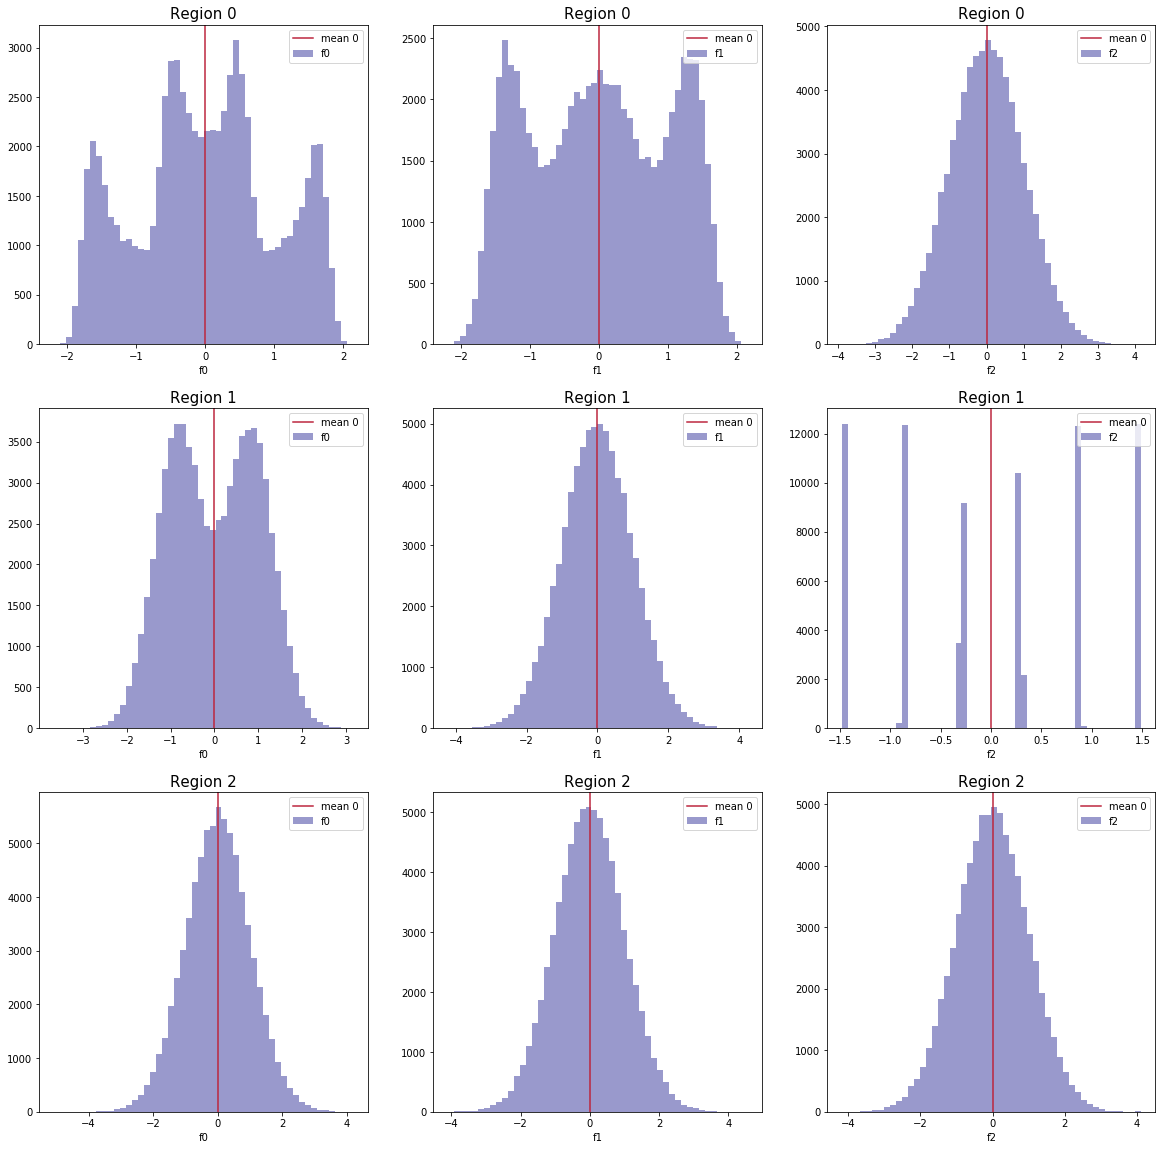

In [13]:
# строим гистограммы признаков после стандартизации

fig, ax = plt.subplots(3,3, figsize=(20,20))

for i in range(3):
    region_name = 'Region ' + str(i)
    for j in range(3):
        column_name = 'f' + str(j)
        
        sns.distplot(features_train_norm_dict[i][column_name], bins=50, kde=False, ax=ax[i,j], label=column_name, color='#000080')
        ax[i,j].set_title(region_name, fontsize=15)
        ax[i,j].axvline(x=0, color='#BC243C', label='mean 0')
        ax[i,j].legend(loc='upper right')

Данные подготовлены - можно приступать к обучению моделей

## Обучение моделей

In [14]:
%%time

# создаем словари для хранения моделей, предсказаний и RMSE

model_dict = {}
predictions_valid_dict = {}
RMSE = {}

# в цикле проходим по всем регионам и обучаем модели

for i in range(3):
    
    model = LR(fit_intercept='True', n_jobs=-1) # инициируем модель
    
    # получаем обучающие фичи и целевой признак из словаря
    features_train = features_train_norm_dict[i] 
    target_train = target_train_dict[i]
    
    # получаем валидационные фичи и целевой признак из словаря
    features_valid = features_valid_norm_dict[i]
    target_valid = target_valid_dict[i]
    
    
    model.fit(features_train, target_train) # обучаем модель
    model_dict.update({i: model}) # сохраняем модель
    
    predictions_valid = model.predict(features_valid) # предсказываем значения целевого признака на валидационной выборке
    predictions_valid_dict.update({i: pd.Series(predictions_valid, index = target_valid.index)}) # сохраняем предсказания в словарь
    
    mse = mean_squared_error(target_valid, predictions_valid) # рассчитываем MSE
    RMSE.update({i: mse**0.5}) # сохраняем в словарь RMSE

CPU times: user 144 ms, sys: 116 ms, total: 260 ms
Wall time: 260 ms


Теперь посмотрим какие именно значения RMSE и среднего запаса сырья мы получили

## Значения RMSE для обученных моделей на валидационной выборке и средний запас предсказанного сырья для каждого региона

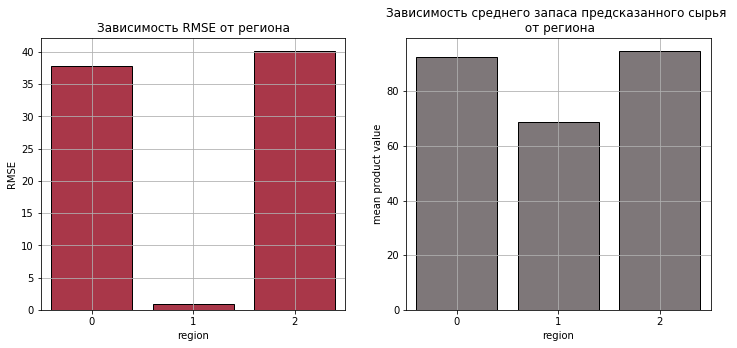

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.barplot(x = 'region', y='RMSE',
            data=pd.DataFrame(data= {'region': list(RMSE.keys()), 'RMSE':list(RMSE.values())}), ax=ax[0], color='#BC243C', edgecolor='black')
ax[0].set_title('Зависимость RMSE от региона')

sns.barplot(x = 'region', y='mean product value',
            data=pd.DataFrame(data= {'region': list(predictions_valid_dict.keys()), 'mean product value':[predictions_valid_dict[i].mean() for i in range(3)]}), ax=ax[1], color='#7f7679', edgecolor='black')
ax[1].set_title('Зависимость среднего запаса предсказанного сырья \n от региона')

ax[1].grid()
ax[0].grid()

Мы получили очень маленькое значение RMSE для региона 1. Это может означать как то, что для это региона наблюдается сильная линейная зависимость между запасами сырья и признаками f0, f1 и f2, так и то, что мы просто ошиблись при обучении модели.

Чтобы убедиться в том, что мы не ошиблись при обучении модели - посчитаем корреляцию между стандартизированными признаками f0, f1 и f2 и целевым признаком product для региона 1

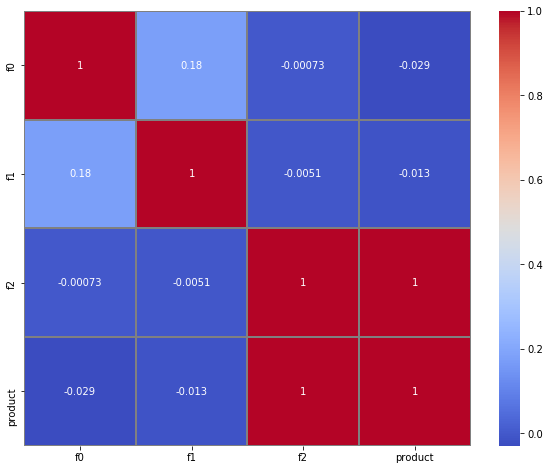

In [16]:
# сводим признаки 'f0', 'f1' и 'f2' и признак 'product' в одной таблице

features = features_valid_norm_dict[1]
target = target_valid_dict[1]
dep_check = features.merge(target, left_index=True, right_index=True)

# считаем коэффициенты корреляции и строим тепловую карту для наглядности

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(dep_check.corr(), cmap='coolwarm', linecolor='grey', linewidths=1, annot=True, ax=ax)

По тепловой карте видно, что признак f2 полностью коррелирует с целевым признаком product.

На всякий случай проведем еще одну проверку - если стандартизированные данные так сильно коррелируют, то и исходные данные также должны демонстрировать зависимость. Построим график зависмости столбцов f1 и product для данных из таблицы data_1

Text(0.5, 0.98, "Зависимость между столбцами 'f1' и 'product' в таблице data_1")

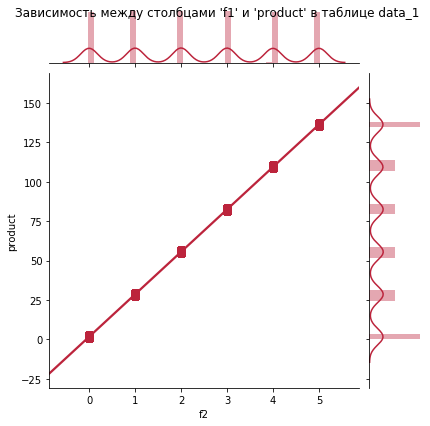

In [17]:
ax = sns.jointplot(x='f2', y='product', data=data_1, kind='reg', color='#BC243C')
ax.fig.suptitle("Зависимость между столбцами 'f1' и 'product' в таблице data_1")

В регионе 1 столбцы f1 и product линейно зависимы

## Вывод

Лучше всего модель линейной регрессии подходит для региона 1 (наименьшее значение RMSE). Тем не менее - в регионе 1 самое маленькое значение среднего запаса предсказанного сырья. Самые большие предсказанные запасы (как и RMSE на валидационной выборке) наблюдаются в регионе 2

# 3. Подготовка к расчёту прибыли

## Значимые константы

In [18]:
#Сначала сохраним в отдельных переменных все данные нашей задачи
budget = 10 * 10**9 # бюджет на разработку скважин в регионе

income = 450 * 10**3 # доход с каждой единицы продукта

total_selected = 500 # количество точек, исследуемых при разведке региона

top_200_selected = 200 # количество точек, которые выбирают для разработки

## Достаточный объем сырья для безубыточной разработки в регионе

Для начала напишем формулу, по которой рассчитывается доход с разработки:

$$
    доход = \sum_{i=1}^{200} (объём  \ сырья_i) \cdot доход \ с \ 1 \ сырья - бюджет \ на \ разработку
$$
Т.к. мы хотим определить достаточный объём сырья для безубыточной разработки, то положим доход равным 0

$$
    \sum_{i=1}^{200} (объём  \ сырья_i)  = \frac{бюджет \ на \ разработку}{доход \ с \ 1 \ сырья}
$$
ну или можно найти достаточный средний объем сырья в регионе:

$$
    \overline {объём  \ сырья}  = \frac{бюджет \ на \ разработку}{доход \ с \ 1 \ сырья \cdot 200}
$$


Ну а теперь расчитаем эту величину, воспользовавшись данными задачи

In [19]:
# рассчитываем минимальный запас сырья и минимальный средний запас сырья для безубыточной разработки

min_mean_oil_stock = budget / (income*top_200_selected)
min_oil_stock = budget / (income)

print('Средний объем сырья, необходимый для безубыточной разработки в регионе - {: .2f} тыс. тонн'.format(min_mean_oil_stock))

Средний объем сырья, необходимый для безубыточной разработки в регионе -  111.11 тыс. тонн


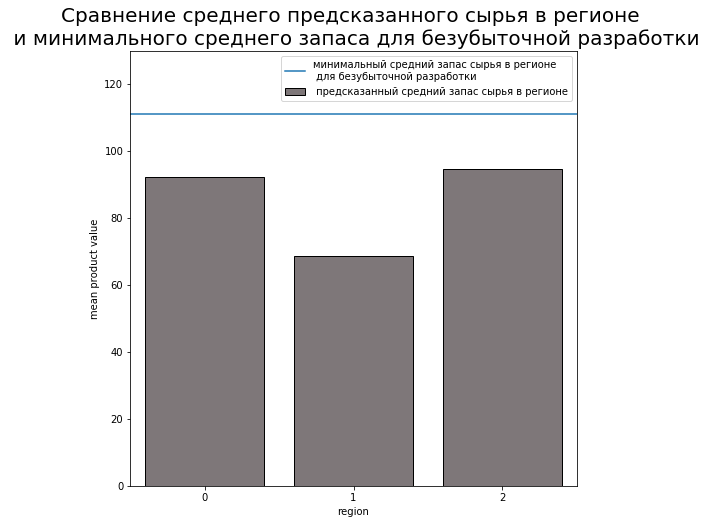

In [20]:
# строим график сравнения среднего предсказанного запаса сырья в регионе и минмального среднего запаса достаточного для безубыточной разработки

fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x = 'region', y='mean product value',
            data=pd.DataFrame(data= {'region': list(predictions_valid_dict.keys()), 'mean product value':[predictions_valid_dict[i].mean() for i in range(3)]}), ax=ax, color='#7f7679', edgecolor='black', label=' предсказанный средний запас сырья в регионе')
plt.axhline(y=min_mean_oil_stock, label='минимальный средний запас сырья в регионе \n для безубыточной разработки')
ax.legend(loc='upper right', fontsize=10)
ax.set_ylim(0, 130)
ax.set_title('Сравнение среднего предсказанного сырья в регионе \n и минимального среднего запаса для безубыточной разработки', fontsize=20)
plt.show()

Несмотря на то, что во всех трех регионах средний предсказанный запас сырья оказался меньше минимального необходимого для безубыточной добычи, стоит учитывать, что во всех регионах существует большое количество точек с практически нулевыми запасами. Эти точки значительно снижают среднее значение. Построим гистограммы предсказанных запасов сырья для всех регионов и отметим на них минимальный средний запас сырья для безубыточной разработки

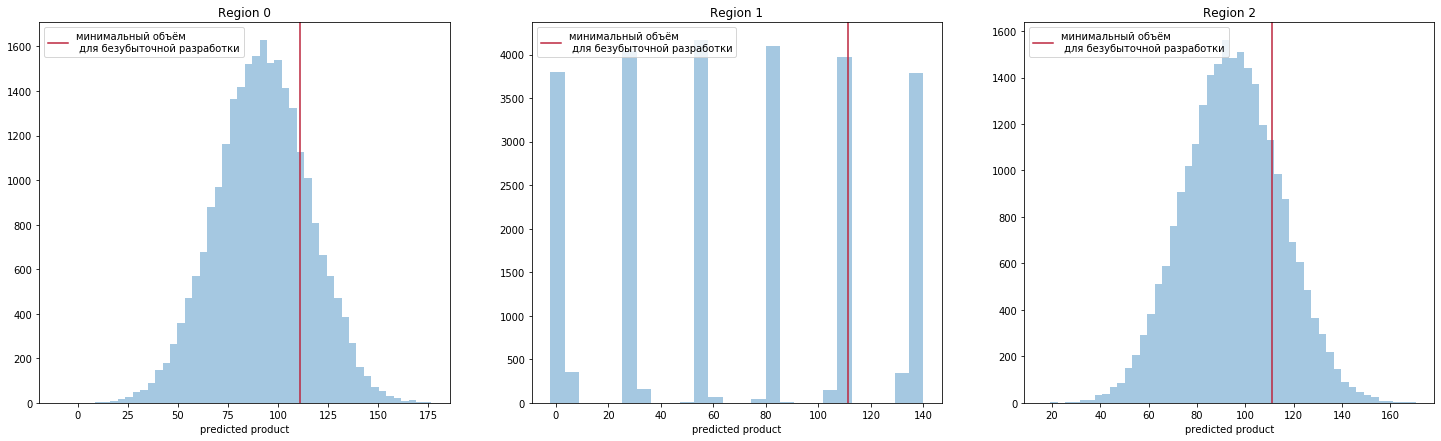

In [21]:
# строим гистограммы предсказанных запасов сырья для каждого региона

fig, ax = plt.subplots(1, 3, figsize=(25,7))

for i in range(3):

    sns.distplot(predictions_valid_dict[i], kde=False, ax=ax[i])
    ax[i].set_title('Region '+str(i))
    ax[i].axvline(x=min_mean_oil_stock, color='#BC243C', label='минимальный объём \n для безубыточной разработки')
    ax[i].set_xlabel(xlabel='predicted product')
    ax[i].legend(loc='upper left')

По этим гистограммам можно сказать, что регионы 0 и 2 выглядят наиболее перспективными для разработки

In [22]:
# функция для расчета дохода

"""
принимает на вход:
    1) выборку значений с предсказанными запасами сырья в шахтах
    2) массив истинных запасов сырья в шахтах
    
возвращает:
    доход с 200 самых наполненных (по предсказанию) шахт. Но доход рассчитывается исходя из истинных значений запасов сырья
"""

def calc_income(predictions, target):
    
    top_200_predicted = predictions.sort_values(ascending=False).head(top_200_selected)
    
    index_top_200 = top_200_predicted.index.values
    
    top_200_target = target[index_top_200]
    
    total_income = top_200_target.sum() * income - budget
    
    return total_income

## Вывод

Ни в одном из регионов средний предсказанный объем сырья не превосходит минимального среднего объема, достаточного для безубыточной разработки. Но это, скорее всего, объясняется тем фактом, что в каждом из регионов пристутствуем значительное количество шахт с практически нулевыми запасами, которые значительно снижают средний показатель.

# 4. Расчёт прибыли и рисков 

## Распределение прибыли в каждом из регионов

In [23]:
# bootstrap

state = np.random.RandomState(42)
total_income_dict = {}
for i in range(3):
    
    predictions = predictions_valid_dict[i]
    target = target_valid_dict[i]
    income_list = []
    
    for j in range(1000):
        
        subsample = predictions.sample(frac=total_selected/predictions.shape[0], replace=False, random_state=state)        
        income_list.append(calc_income(subsample, target))
    
    total_income_dict.update({i : pd.Series(income_list)})

Теперь построим гистограммы распределения выручки для каждого региона

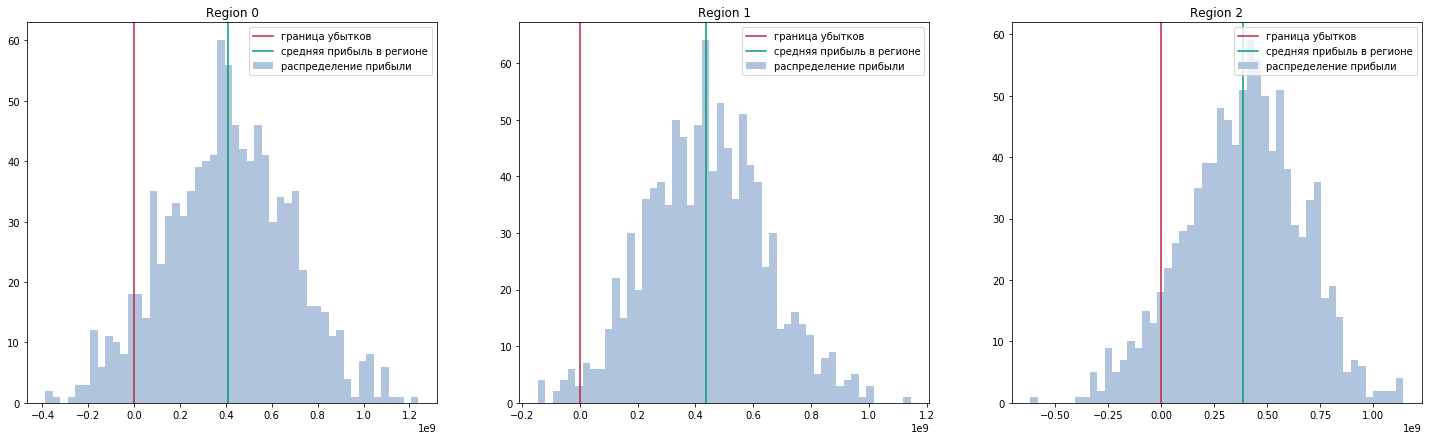

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(25,7))

for i in range(3):
    
    #sns.distplot(pd.Series(total_income_dict[i]), ax=ax[i])
    
    ax[i].hist(total_income_dict[i], bins=50, label='распределение прибыли', color='lightsteelblue')
    ax[i].axvline(x=0, color='#BC243C', label='граница убытков')
    ax[i].axvline(x=total_income_dict[i].mean(), color='#009B77', label='средняя прибыль в регионе')
    ax[i].legend(loc='upper right')
    ax[i].set_title('Region ' + str(i))

## Средняя прибыль

Рассчитаем среднюю прибыль в каждом регионе

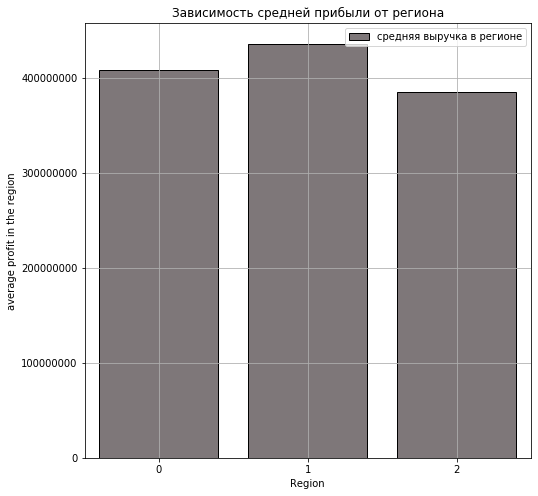

In [25]:
# средняя прибыль

mean_region_income = []

for i  in range(3):
    mean_region_income.append(total_income_dict[i].mean())
    

fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x = 'index', y=0, data=pd.DataFrame(data=mean_region_income).reset_index(), ax=ax, color='#7f7679', edgecolor='black', label='средняя выручка в регионе')
ax.set_xlabel(xlabel='Region')
ax.set_ylabel(ylabel='average profit in the region')
ax.set_title('Зависимость средней прибыли от региона')
ax.legend(loc='best')

ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.grid()

Пока что лучшим для разработки кажется регион 1, так как средняя прибыль в нем выше, чем в остальных регионах

## Доверительный интервал

Найдем доверительные интервалы для прибыли в каждом регионе

Регион 0 - 95% доверительный интервал = от -138,678,493.8819604 до 952,414,908.4140642

Регион 1 - 95% доверительный интервал = от 28,878,732.655240346 до 865,831,912.5385565

Регион 2 - 95% доверительный интервал = от -185,862,734.65718856 до 885,439,396.2295961



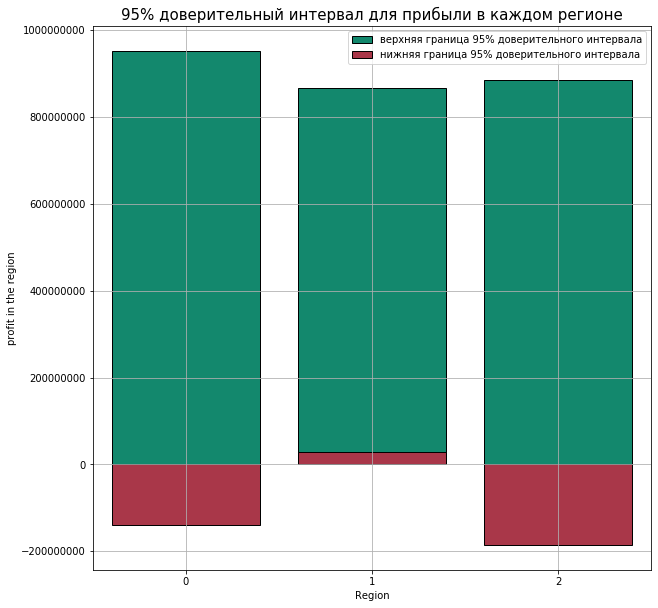

In [26]:
minimum = []
maximum = []

for i in range(3):
    values = total_income_dict[i]
    
    minimum.append(values.quantile(0.025))
    maximum.append(values.quantile(0.975))
    
    print('Регион {} - 95% доверительный интервал = от {:,} до {:,}'.format(i, minimum[i], maximum[i]))
    print()
    


fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x = 'index', y='max', data=pd.DataFrame(data = {'min':minimum, 'max':maximum}).reset_index(), ax=ax, color='#009B77', edgecolor='black', label='верхняя граница 95% доверительного интервала')
sns.barplot(x = 'index', y='min', data=pd.DataFrame(data = {'min':minimum, 'max':maximum}).reset_index(), ax=ax, color='#BC243C', edgecolor='black', label='нижняя граница 95% доверительного интервала')
ax.set_xlabel(xlabel='Region')
ax.set_ylabel(ylabel='profit in the region')
ax.set_title('95% доверительный интервал для прибыли в каждом регионе', fontsize=15)
ax.legend()

ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.grid()

Обратим внимание, что только во втором регионе нижняя граница 95% доверительного интервала лежит в области положительных значений.

## Риск убытков

Оценим вероятность того, что разработка в регионе будет убыточной. У нас уже есть распределение прибыли в регионах. Вероятность убыточной разработки фактически равна квантилю, значение которого равно 0.0. То есть фактически нам нужно применить функцию обратную dataframe.quantile()

In [27]:
# создаем список с рисками убытков для каждого региона

loss_chanse = []

for i in range(3):
    
    chanse = stats.percentileofscore(total_income_dict[i], 0)
    loss_chanse.append(chanse)
    
    
loss_chanse

[7.4, 1.7, 8.6]

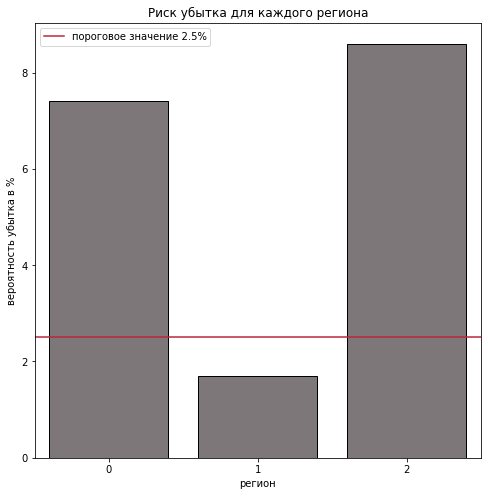

In [28]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x = 'index', y=0, data=pd.DataFrame(data=loss_chanse).reset_index(), ax=ax, color='#7f7679', edgecolor='black')
ax.set_xlabel(xlabel='регион')
ax.set_ylabel(ylabel='вероятность убытка в %')
ax.set_title('Риск убытка для каждого региона')
ax.axhline(y=2.5, label='пороговое значение 2.5%', color='#BC243C')
ax.legend(loc='best')

По гистограмме видно, что только в регионе 1 вероятность убытка при разработке меньше 2.5 процентов

## Рекомендованный регион для разработки

Исходя из данных:

* средней прибыль по региону

* 95% доверительного интервала для прибыль

* рисков убытка

К разработке можно рекомендовать только регион 1, так как:

* самая высокая средняя прибыль по региону

* только в этом регионе 95% доверительный интервал лежит полностью в области положительных значений

* только в этом регионе риск убытка меньше 2.5%